# 1. Importing

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score, precision_score, recall_score
from sklearn import datasets, linear_model, preprocessing
from sklearn.model_selection import train_test_split

import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Activation
from keras.utils.vis_utils import plot_model
from IPython.display import clear_output
from keras import optimizers
from keras.models import load_model
from keras.callbacks import Callback

%matplotlib inline


# 2. Investigating the Data


In [5]:
features = ['MIP', 'SIP','EKIP','SKIP','MDM-SR','SDM-SR','EKDM-SR','SKDM-SR','Target'] # Abbreviating features
df =  pd.read_csv('pulsar_stars.csv',
                names=features,na_values='?',header=None, skiprows = 1)
print(df.head(6))

          MIP        SIP      EKIP      SKIP    MDM-SR     SDM-SR    EKDM-SR  \
0  140.562500  55.683782 -0.234571 -0.699648  3.199833  19.110426   7.975532   
1  102.507812  58.882430  0.465318 -0.515088  1.677258  14.860146  10.576487   
2  103.015625  39.341649  0.323328  1.051164  3.121237  21.744669   7.735822   
3  136.750000  57.178449 -0.068415 -0.636238  3.642977  20.959280   6.896499   
4   88.726562  40.672225  0.600866  1.123492  1.178930  11.468720  14.269573   
5   93.570312  46.698114  0.531905  0.416721  1.636288  14.545074  10.621748   

      SKDM-SR  Target  
0   74.242225       0  
1  127.393580       0  
2   63.171909       0  
3   53.593661       0  
4  252.567306       0  
5  131.394004       0  


In [6]:
# Checking information about the dtypes and non-null rows in the dataset
df.info()
print('\n Since dtypes are all floating point numbers or integers, and there are no null values in the dataset \n No need to perform cleaning')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
MIP        17898 non-null float64
SIP        17898 non-null float64
EKIP       17898 non-null float64
SKIP       17898 non-null float64
MDM-SR     17898 non-null float64
SDM-SR     17898 non-null float64
EKDM-SR    17898 non-null float64
SKDM-SR    17898 non-null float64
Target     17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB

 Since dtypes are all floating point numbers or integers, and there are no null values in the dataset 
 No need to perform cleaning


In [7]:
# Getting the statistical details of the dataset
df.describe()

,MIP,SIP,EKIP,SKIP,MDM-SR,SDM-SR,EKDM-SR,SKDM-SR,Target
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


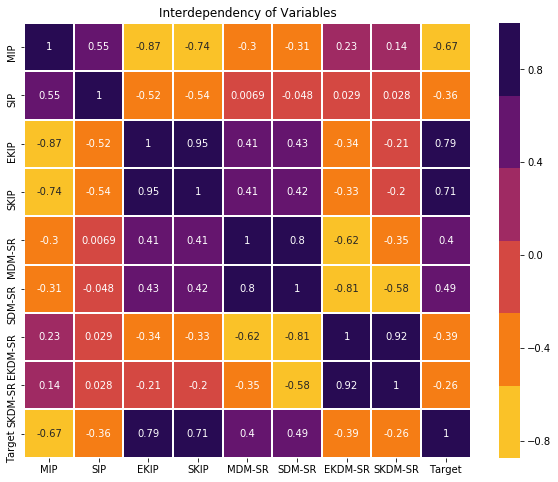

In [8]:
correlation = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation,annot=True,
            cmap=sns.color_palette("inferno_r"),
            linewidth=1,edgecolor="k")
plt.title("Interdependency of Variables")
plt.show()

# 3. Pre-Processing Data

In [9]:
# Changing dataframe to array and separating target values from feature values
pulsar_x= np.array((df.loc[:,'MIP':'SKDM-SR']))
pulsar_y= np.array((df.loc[:,'Target']))
pulsar_x=pulsar_x.reshape(pulsar_x.shape[0],8)
pulsar_y=pulsar_y.reshape(pulsar_y.shape[0],1)
print(pulsar_x.shape)
print(pulsar_y.shape)


(17898, 8)
(17898, 1)


In [10]:
# Scaling Data
x_scale = preprocessing.scale(pulsar_x)
# splitting data into a 75:25 train test split
x_train, x_test, y_train, y_test = train_test_split(x_scale, pulsar_y, test_size = .25)
y_train = y_train.reshape((y_train.shape[0]), 1)
print(y_train.shape)
print(x_train.shape)
print(y_test.shape)

(13423, 1)
(13423, 8)
(4475, 1)


# 4. Logistic Regression Without Feature Transformation

##  4.1 With L1 Regularization:

In [11]:
# Initializing lists for different accuracy values for train and test sets corresponding to different values of parameter C
acc_train_logreg = [] 
acc_test_logreg = []
Yhat_test_logreg = []
c_logreg = []
prec_test_logreg = []
fscore_test_logreg =[]

In [12]:
def logreg_model_L1(c , X_train, Y_train, X_test, Y_test):
    # Create an object of logistic regression model using linear_model.
    
  
    logreg = linear_model.LogisticRegression(C=c,penalty='l1', warm_start=True, solver='saga', max_iter = 5000)
    
    logreg.fit(X_train, Y_train)
    
    Yhat_train = logreg.predict(X_train)
    
  
    # Adding training accuracy to acc_train_logreg
    acc_train = np.mean(Yhat_train == Y_train)
    acc_train_logreg.append(acc_train)
    
    # Printing values of C and no. of iterations
    print("For C = %f" % c)
    print("Accuracy on training data = %f" % acc_train)
#     prec_train , recal_train , fscore_train,_ = precision_recall_fscore_support(Y_train, Yhat_train, average = 'weighted')
#     print("Precision on train data = %f" % prec)
#     print("Recal on train data = %f" % recal)
#     print("fscore on train data = %f" % fscore)
  # Find the prediction on test sets
    Yhat_test = logreg.predict(X_test)
    # Adding testing accuracy to acc_test_logreg
    acc_test = np.mean(Yhat_test == Y_test)
    acc_test_logreg.append(acc_test)
    print("Accuracy on test data = %f" % acc_test)
    prec , recal , fscore,_ = precision_recall_fscore_support(Y_test, Yhat_test, average = 'weighted')
    prec_test_logreg.append(prec)
    fscore_test_logreg.append(fscore)
    print("Precision on test data = %f" % prec)
    print("Recal on test data = %f" % recal)
    print("fscore on test data = %f" % fscore)
    
   # Find precision, recall, and fscore 
    
    # Appending value of c for graphing purposes
    c_logreg.append(c)
    Yhat_test_logreg.append(Yhat_test)

In [13]:
# Call the above function i.e. logreg_model with different values of parameter 'c'.
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10,100]

for c in c_values:
    logreg_model_L1(c, x_train, y_train, x_test, y_test)    
    

C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.000100
Accuracy on training data = 0.909409
Accuracy on test data = 0.905475
Precision on test data = 0.819885
Recal on test data = 0.905475
fscore on test data = 0.860557


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.001000
Accuracy on training data = 0.874883
Accuracy on test data = 0.873218
Precision on test data = 0.946889
Recal on test data = 0.944358
fscore on test data = 0.933833


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.010000
Accuracy on training data = 0.849994
Accuracy on test data = 0.845854
Precision on test data = 0.970368
Recal on test data = 0.970950
fscore on test data = 0.969301


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.100000
Accuracy on training data = 0.845724
Accuracy on test data = 0.841505
Precision on test data = 0.975362
Recal on test data = 0.975866
fscore on test data = 0.974881


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 1.000000
Accuracy on training data = 0.843894
Accuracy on test data = 0.839512
Precision on test data = 0.977406
Recal on test data = 0.977877
fscore on test data = 0.977128


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 10.000000
Accuracy on training data = 0.843955
Accuracy on test data = 0.839330
Precision on test data = 0.977636
Recal on test data = 0.978101
fscore on test data = 0.977372


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 100.000000
Accuracy on training data = 0.843955
Accuracy on test data = 0.839330
Precision on test data = 0.977636
Recal on test data = 0.978101
fscore on test data = 0.977372


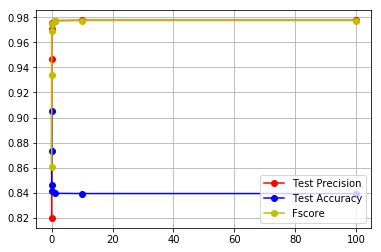

In [14]:
plt.plot(c_logreg, prec_test_logreg, 'ro-') 
plt.plot(c_logreg, acc_test_logreg,'bo-') 
plt.plot(c_logreg, fscore_test_logreg,'yo-') 
plt.grid()
# Use the following function to have a legend
plt.legend(['Test Precision', 'Test Accuracy', 'Fscore'], loc='lower right')

## 4.2 With L2 Regularization

In [15]:
acc_train_logreg_L2 = [] 
acc_test_logreg_L2 = []
Yhat_test_logreg_L2 = []
c_logreg_L2 = []
prec_test_logreg.clear()
fscore_test_logreg.clear()
print(prec_test_logreg)


[]


In [16]:
def logreg_model_L2(c , X_train, Y_train, X_test, Y_test):
    # Create an object of logistic regression model using linear_model.
    
  
    logreg = linear_model.LogisticRegression(C=c, warm_start=True, solver='saga', max_iter = 5000)
    
    logreg.fit(X_train, Y_train)
    
    Yhat_train = logreg.predict(X_train)
    
  
    # Adding training accuracy to acc_train_logreg
    acc_train = np.mean(Yhat_train == Y_train)
    acc_train_logreg_L2.append(acc_train)
    
    # Printing values of C and no. of iterations
    print("For C = %f" % c)
    print("Accuracy on training data = %f" % acc_train)
#     prec_train , recal_train , fscore_train,_ = precision_recall_fscore_support(Y_train, Yhat_train, average = 'weighted')
#     print("Precision on train data = %f" % prec)
#     print("Recal on train data = %f" % recal)
#     print("fscore on train data = %f" % fscore)
  # Find the prediction on test sets
    Yhat_test = logreg.predict(X_test)
    # Adding testing accuracy to acc_test_logreg
    acc_test = np.mean(Yhat_test == Y_test)
    acc_test_logreg_L2.append(acc_test)
    print("Accuracy on test data = %f" % acc_test)
    prec , recal , fscore,_ = precision_recall_fscore_support(Y_test, Yhat_test, average = 'weighted')
    prec_test_logreg.append(prec)
    fscore_test_logreg.append(fscore)
    print("Precision on test data = %f" % prec)
    print("Recal on test data = %f" % recal)
    print("fscore on test data = %f" % fscore)
    
   # Find precision, recall, and fscore 
    
    # Appending value of c for graphing purposes
    c_logreg_L2.append(c)
    Yhat_test_logreg_L2.append(Yhat_test)

In [ ]:
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10,100]

for c in c_values:
    logreg_model_L2(c, x_train, y_train, x_test, y_test)  

C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.000100
Accuracy on training data = 0.891902
Accuracy on test data = 0.891340
Precision on test data = 0.928954
Recal on test data = 0.922905
fscore on test data = 0.897934


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.001000
Accuracy on training data = 0.863353
Accuracy on test data = 0.859808
Precision on test data = 0.958029
Recal on test data = 0.957765
fscore on test data = 0.952852


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.010000
Accuracy on training data = 0.851031
Accuracy on test data = 0.846760
Precision on test data = 0.969227
Recal on test data = 0.969832
fscore on test data = 0.968015


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.100000
Accuracy on training data = 0.846883
Accuracy on test data = 0.843136
Precision on test data = 0.974286
Recal on test data = 0.974749
fscore on test data = 0.973570


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 1.000000
Accuracy on training data = 0.844443
Accuracy on test data = 0.840599
Precision on test data = 0.976509
Recal on test data = 0.976983
fscore on test data = 0.976117


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 10.000000
Accuracy on training data = 0.844077
Accuracy on test data = 0.839512
Precision on test data = 0.977406
Recal on test data = 0.977877
fscore on test data = 0.977128


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 100.000000
Accuracy on training data = 0.843955
Accuracy on test data = 0.839330
Precision on test data = 0.977636
Recal on test data = 0.978101
fscore on test data = 0.977372


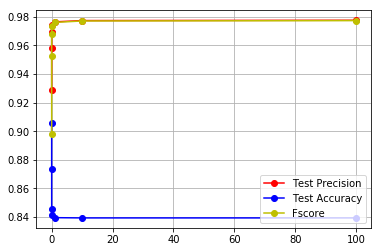

In [ ]:
plt.plot(c_logreg_L2, prec_test_logreg, 'ro-') 
plt.plot(c_logreg_L2, acc_test_logreg,'bo-') 
plt.plot(c_logreg_L2, fscore_test_logreg,'yo-') 
plt.grid()
# Use the following function to have a legend
plt.legend(['Test Precision', 'Test Accuracy','Fscore'], loc='lower right')

# 4.3 Logistic Regression using Polynomial Feature Transformation
## 4.3.1 Using L1 Regularization without PCA

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
ply = PolynomialFeatures(degree = 2)

In [ ]:
X_transformed_train = ply.fit_transform(x_train)
X_transformed_test = ply.fit_transform(x_test)
print(X_transformed_train.shape)
print(X_transformed_test.shape)

(13423, 45)
(4475, 45)


In [ ]:
acc_train_logreg = []
acc_test_logreg = []
c_logreg = []
fscore_test_logreg.clear()
prec_test_logreg.clear()


# Call the function logreg_model.
for c in c_values:
    logreg_model_L1(c, X_transformed_train, y_train, X_transformed_test, y_test)
    
plt.plot(c_logreg, prec_test_logreg, 'ro-') 
plt.plot(c_logreg, acc_test_logreg,'bo-') 
plt.plot(c_logreg, fscore_test_logreg,'yo-')
plt.grid()
plt.legend(['Test Precision', 'Test Accuracy','Fscore'], loc='upper right')
    


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.000100
Accuracy on training data = 0.909104
Accuracy on test data = 0.905475
Precision on test data = 0.819885
Recal on test data = 0.905475
fscore on test data = 0.860557


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.001000
Accuracy on training data = 0.872199
Accuracy on test data = 0.871043
Precision on test data = 0.948638
Recal on test data = 0.946592
fscore on test data = 0.937188


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.010000
Accuracy on training data = 0.849994
Accuracy on test data = 0.845854
Precision on test data = 0.970368
Recal on test data = 0.970950
fscore on test data = 0.969301


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.100000
Accuracy on training data = 0.844504
Accuracy on test data = 0.837881
Precision on test data = 0.977583
Recal on test data = 0.978101
fscore on test data = 0.977480


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 4.3.2 Using L1 Regularization with PCA


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(.95)
pca_x_transformed_train = pca.fit_transform(X_transformed_train)
pca_x_transformed_test = pca.transform(X_transformed_test)
pca.n_components_

In [ ]:
acc_train_logreg = []
acc_test_logreg = []
c_logreg = []
fscore_test_logreg.clear()
prec_test_logreg.clear()

# Call the function logreg_model.
for c in c_values:
    logreg_model_L1(c, X_transformed_train, y_train, X_transformed_test, y_test)
    
plt.plot(c_logreg, prec_test_logreg, 'ro-') 
plt.plot(c_logreg, acc_test_logreg,'bo-') 
plt.plot(c_logreg, fscore_test_logreg,'yo-')
plt.grid()
plt.legend(['Test Precision', 'Test Accuracy', 'Fscore'], loc='upper right')
    

## 4.3.3 Using L2 Regularization without PCA

In [ ]:
acc_train_logreg_L2 = [] 
acc_test_logreg_L2 = []
Yhat_test_logreg_L2 = []
c_logreg_L2 = []
fscore_test_logreg.clear()
prec_test_logreg.clear()
# Call the function logreg_model.
for c in c_values:
    logreg_model_L2(c, X_transformed_train, y_train, X_transformed_test, y_test)
    
plt.plot(c_logreg, prec_test_logreg, 'ro-') 
plt.plot(c_logreg, acc_test_logreg,'bo-') 
plt.plot(c_logreg, fscore_test_logreg,'yo-') 
plt.grid()
plt.legend(['Test Precision', 'Test Accuracy', 'Fscore'], loc='upper right')
    


## 4.3.4 Using L2 regularization with PCA

In [ ]:
pca = PCA(.95)
pca_x_transformed_train = pca.fit_transform(X_transformed_train)
pca_x_transformed_test = pca.transform(X_transformed_test)
pca.n_components_

In [ ]:
acc_train_logreg_L2 = [] 
acc_test_logreg_L2 = []
Yhat_test_logreg_L2 = []
c_logreg_L2 = []
fscore_test_logreg.clear()
prec_test_logreg.clear()
# Call the function logreg_model.
for c in c_values:
    logreg_model_L2(c, X_transformed_train, y_train, X_transformed_test, y_test)
    
plt.plot(c_logreg, prec_test_logreg, 'ro-') 
plt.plot(c_logreg, acc_test_logreg,'bo-') 
plt.plot(c_logreg, fscore_test_logreg,'yo-') 
plt.grid()
plt.legend(['Test Precision', 'Test Accuracy', 'Fscore'], loc='upper right')

# 5. Support Vector Machine (SVM)

## 5.1 Using Linear Kernel

In [ ]:
acc_train_svm_linear = []
acc_test_svm_linear = []
c_svm_linear = []
prec_test_svm_linear = []
fscore_test_svm_linear = []

In [ ]:
from sklearn import svm

# Complete the function below:
# In this function and next 2 functions, we are not passing the data matrices as parameters 
# because we can use global variables inside the functions.
def svm_linear(c, X_train, Y_train, X_test, Y_test):
    # TODO - Create an object of svm.SVC(probability = False, kernel = 'linear', C = c) - 5 points
    svc_linear = svm.SVC(probability = False, kernel = 'linear', C = c)
    
    # TODO - Fit the classifier on the training set - 5 points
    svc_linear.fit(X_train, Y_train)
    # TODO - Find the prediction and accuracy on the training set - 5 points
    Yhat_svc_linear_train = svc_linear.predict(X_train)
    acc_train = np.mean(Yhat_svc_linear_train == Y_train)
    
    # Adding testing accuracy to acc_train_svm
    acc_train_svm_linear.append(acc_train)
    print('Train Accuracy = {0:f}'.format(acc_train))
    
    # TODO - Find the prediction and accuracy on the test set - 5 points
    Yhat_svc_linear_test = svc_linear.predict(X_test)
    acc_test = np.mean(Yhat_svc_linear_test == Y_test)
    
    # Adding testing accuracy to acc_test_svm
    acc_test_svm_linear.append(acc_test)
    print('Test Accuracy = {0:f}'.format(acc_test))
    prec , recal , fscore,_ = precision_recall_fscore_support(Y_test, Yhat_svc_linear_test, average = 'weighted')
    prec_test_svm_linear.append(prec)
    fscore_test_svm_linear.append(fscore)
    print("Precision on test data = %f" % prec)
    print("Recal on test data = %f" % recal)
    print("fscore on test data = %f" % fscore)
    
    
    # Appending value of c for graphing purposes
    c_svm_linear.append(c)
    

In [ ]:
print(c_values)
for c in c_values:
    svm_linear(c,x_train,y_train, x_test, y_test)


In [ ]:
print(acc_test_svm_linear)
# Plot training accuracy(Y-axis) v/s 'c' on X - Axis.
# Plot test accuracy(Y-Axis) v/s 'c' on X - Axis.

plt.plot(c_svm_linear, prec_test_svm_linear, 'ro-') 
plt.plot(c_svm_linear, acc_test_svm_linear,'bo-') 
plt.plot(c_svm_linear, fscore_test_svm_linear,'yo-') 
plt.grid()

# Use the following function to have a legend
plt.legend(['Test Precision', 'Test Accuracy','Fscore'], loc='upper right')

## 5.2 Using Radial Basis Function (RBF) Kernel

In [ ]:
acc_train_svm_rbf = []
acc_test_svm_rbf = []
c_svm_rbf = []
prec_test_svm_rbf = []
fscore_test_svm_rbf = []

In [ ]:
from sklearn import svm

# Complete the function below:
# In this function and next 2 functions, we are not passing the data matrices as parameters 
# because we can use global variables inside the functions.
def svm_rbf(c,X_train,Y_train, X_test, Y_test):
    # TODO - Create an object of svm.SVC(probability = False, kernel = 'rbf', C = c) - 5 points
    svc_rbf = svm.SVC(probability = False, kernel = 'rbf', C = c)
    
    # TODO - Fit the classifier on the trai  ning set - 5 points
    svc_rbf.fit(X_train, Y_train)
    # TODO - Find the prediction and accuracy on the training set - 5 points
    Yhat_svc_rbf_train = svc_rbf.predict(X_train)
    acc_train = np.mean(Yhat_svc_rbf_train == Y_train)
    
    # Adding testing accuracy to acc_train_svm
    acc_train_svm_rbf.append(acc_train)
    print('Train Accuracy = {0:f}'.format(acc_train))
    
    # TODO - Find the prediction and accuracy on the test set - 5 points
    Yhat_svc_rbf_test = svc_rbf.predict(X_test)
    acc_test = np.mean(Yhat_svc_rbf_test == Y_test)
    
    # Adding testing accuracy to acc_test_svm
    acc_test_svm_rbf.append(acc_test)
    print('Test Accuracy = {0:f}'.format(acc_test))
    prec , recal , fscore,_ = precision_recall_fscore_support(Y_test, Yhat_svc_rbf_test, average = 'weighted')
    prec_test_svm_rbf.append(prec)
    fscore_test_svm_rbf.append(fscore)
    print("Precision on test data = %f" % prec)
    print("Recal on test data = %f" % recal)
    print("fscore on test data = %f" % fscore)
    # Appending value of c for graphing purposes
    c_svm_rbf.append(c)
    

In [ ]:
for c in c_values:
    svm_rbf(c,x_train,y_train, x_test, y_test)

In [ ]:
plt.plot(c_svm_rbf, prec_test_svm_rbf, 'ro-') 
plt.plot(c_svm_rbf, acc_test_svm_rbf,'bo-') 
plt.plot(c_svm_rbf, fscore_test_svm_rbf,'yo-') 
plt.grid()
# Use the following function to have a legend
plt.legend(['Test Precision', 'Test Accuracy', 'Fscore'], loc='lower right')

## 5.3 Using Polynomial Kernel

In [ ]:
acc_train_svm_poly = []
acc_test_svm_poly = []
c_svm_poly = []
prec_test_svm_poly = []
fscore_test_svm_poly = []

In [ ]:
def svm_polynomial(c,X_train,Y_train, X_test, Y_test):
    # TODO - Create an object of svm.SVC(probability = False, kernel = 'poly', C = c) - 5 points
    svc_polynomial = svm.SVC(probability = False, kernel = 'poly', C = c)

    
    # TODO - Fit the classifier on the training set - 5 points
    # Use A and B to train and C and D to test.
    svc_polynomial.fit(X_train, Y_train)
    # TODO - Find the prediction and accuracy on the training set - 5 points
    Yhat_svc_polynomial_train = svc_polynomial.predict(X_test)
    acc_train = np.mean(Yhat_svc_polynomial_train == Y_train)
    
    # Adding testing accuracy to acc_train_svm
    acc_train_svm_poly.append(acc_train)
    print('Train Accuracy = {0:f}'.format(acc_train))
    
    # TODO - Find the prediction and accuracy on the test set - 5 points
    Yhat_svc_polynomial_test = svc_polynomial.predict(X_test)
    acc_test = np.mean(Yhat_svc_polynomial_test == Y_test)
    
    # Adding testing accuracy to acc_test_svm
    acc_test_svm_poly.append(acc_test)
    print('Test Accuracy = {0:f}'.format(acc_test))
    prec , recal , fscore,_ = precision_recall_fscore_support(Y_test, Yhat_svc_polynomial_test, average = 'weighted')
    prec_test_svm_poly.append(prec)
    fscore_test_svm_poly.append(fscore)
    print("Precision on test data = %f" % prec)
    print("Recal on test data = %f" % recal)
    print("fscore on test data = %f" % fscore)
    
    # Appending value of c for graphing purposes
    c_svm_poly.append(c)

In [ ]:
for c in c_values:
    svm_polynomial(c,x_train,y_train, x_test, y_test)

In [ ]:
plt.plot(c_svm_poly,prec_test_svm_poly, 'ro-') 
plt.plot(c_svm_poly,acc_test_svm_poly,'bo-')
plt.plot(c_svm_poly,fscore_test_svm_poly,'yo-') 
plt.grid()
# Use the following function to have a legend
plt.legend(['Test Precision', 'Test Accuracy','Fscore'], loc='lower right')


# 6. Neural Networks
In the following section, we will run our data set through various neural networks with different hyper parameters. We will vary the activation function (tanh, reLU, sigmoid), the number of inputs in the hidden layer (10, 100, 200), and the number of hidden layers (1, 2, 5, with 100 nodes in each hidden layer). Weights and biases will be initialized randomly.  

In [ ]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
     self.val_f1s = []
     self.val_recalls = []
     self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
     val_predict = (np.asarray(self.model.predict(self.validation_data[0])).round())
     val_targ = self.validation_data[1]
     _val_f1 = f1_score(val_targ, val_predict)
     _val_recall = recall_score(val_targ, val_predict)
     _val_precision = precision_score(val_targ, val_predict)
    
     self.val_f1s.append(_val_f1)
     self.val_recalls.append(_val_recall)
     self.val_precisions.append(_val_precision)
        
     print (" — val_f1: %f — val_precision: %f — val_recall %f" % 
            (_val_f1, _val_precision, _val_recall))
     return

metrics = Metrics()


# Build and compile our network with user given parameters
def neural_network(nin, nh, nout, nhl, act):
    model = Sequential();
    for x in range(0,nhl):
        model.add(Dense(nh, input_shape=(nin,), activation=act, name="hidden"+str(x)))
    model.add(Dense(nout, activation="sigmoid", name="output"))  
    # Compile model
    opt = optimizers.Adam(lr=0.001) 
    model.compile(optimizer=opt, 
             loss="binary_crossentropy",
             metrics=["accuracy"])  
    return model

# Train and validate our network on training and test data
def train_network(model, x_train, y_train, x_test, y_test):
    history = model.fit(x_train, y_train, epochs=10, batch_size=100, 
                validation_data=(x_test, y_test), callbacks=[metrics], verbose=1)
    return history

# Plot network accuracy
def plot_acc(history, title):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

# Plot network loss
def plot_loss(history, title):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['acc', 'val_acc'], loc='upper right')
    plt.show()
    


# 6.1 Network 8-100-1, Sigmoid

In [ ]:
K.clear_session()

modelArr = []
historyArr = []
modelNameArr = []
# Number of nodes in input layer = number of features = 8
nin = x_train.shape[1];
# Number of hidden layer nodes
nh = 100;
# Number of output nodes
nout = 1;


model_sig = neural_network(nin, nh, nout, 1, "sigmoid")
sig_history = train_network(model_sig, x_train, y_train, x_test, y_test);
model_sig.summary()
plot_acc(sig_history, "Sigmoid Accuracy")
plot_loss(sig_history, "Sigmoid Loss")

modelArr.append(model_sig)
historyArr.append(sig_history)
modelNameArr.append("model_sig")

score, acc = model_sig.evaluate(x_test, y_test, verbose = 0)
print("Validation Accuracy = %f" % acc)


## 6.2 Network 8-100-1, ReLU

In [ ]:
nh = 100;
    
model_relu = neural_network(nin, nh, nout, 1, "relu")
model_relu.summary()
relu_history = train_network(model_relu, x_train, y_train, x_test, y_test);
plot_acc(relu_history, "ReLu Accuracy")
plot_loss(relu_history, "ReLU Loss")

modelArr.append(model_relu)
historyArr.append(relu_history)
modelNameArr.append("model_relu")

score, acc = model_relu.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## 6.3 Network 8-100-1, tanh

In [ ]:
nh = 100;
    
model_tanh = neural_network(nin, nh, nout, 1, "relu")
model_tanh.summary()
tanh_history = train_network(model_tanh, x_train, y_train, x_test, y_test);
plot_acc(tanh_history, "Tanh Accuracy")
plot_loss(tanh_history, "Tanh Loss")

modelArr.append(model_tanh)
historyArr.append(tanh_history)
modelNameArr.append("model_tanh")

score, acc = model_tanh.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## 6.4 Network 8-10-1, sigmoid

In [ ]:
# We are changing the number of hidden units here
nh = 10;
    
model_ten = neural_network(nin, nh, nout, 1, "sigmoid")
model_ten.summary()
ten_history = train_network(model_ten, x_train, y_train, x_test, y_test);
plot_acc(ten_history, "10 Hidden Unit Accuracy")
plot_loss(ten_history, "10 Hidden Unit Loss")

modelArr.append(model_ten)
historyArr.append(ten_history)
modelNameArr.append("model_ten")

score, acc = model_ten.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## 6.5 Network 8-200-1, sigmoid

In [ ]:
nh = 200;
    
model_twohund = neural_network(nin, nh, nout, 1, "sigmoid")
model_twohund.summary()
twohund_history = train_network(model_twohund, x_train, y_train, x_test, y_test);
plot_acc(twohund_history, "200 Hidden Unit Accuracy")
plot_loss(twohund_history, "200 Hidden Unit Loss")

modelArr.append(model_twohund)
historyArr.append(twohund_history)
modelNameArr.append("model_twohund")

score, acc = model_twohund.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## 6.6 Network 8-100-100-1 sigmoid

In [ ]:
nh = 100;
num_layers = 2;
    
model_twolayer = neural_network(nin, nh, nout, num_layers, "sigmoid")
model_twolayer.summary()
twolayer_history = train_network(model_twolayer, x_train, y_train, x_test, y_test);
plot_acc(twolayer_history, "2 Hidden Layer (100) Accuracy")
plot_loss(twolayer_history, "2 Hidden Layer (100) Loss")

modelArr.append(model_twolayer)
historyArr.append(twolayer_history)
modelNameArr.append("model_twolayer")

score, acc = model_twolayer.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## 6.7 Network 8-100-100-100-100-100-1, sigmoid

In [ ]:
nh = 100;
num_layers = 5;
    
model_fivelayer = neural_network(nin, nh, nout, num_layers, "sigmoid")
model_fivelayer.summary()
fivelayer_history = train_network(model_fivelayer, x_train, y_train, x_test, y_test);
plot_acc(fivelayer_history, "5 Hidden Layer (100) Accuracy")
plot_loss(fivelayer_history, "5 Hidden Layer (100) Loss")

modelArr.append(model_fivelayer)
historyArr.append(fivelayer_history)
modelNameArr.append("model_fivelayer")

score, acc = model_fivelayer.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## Accuracy Graphs of All Models

In [ ]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.tight_layout()

for index, history in enumerate(historyArr):
    plt.subplot(3,3,index+1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(modelNameArr[index] + " Accuracy")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['acc', 'val_acc'], loc='lower right')

plt.show()

## Loss Graphs of All Models

In [ ]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.tight_layout()

for index, history in enumerate(historyArr):
    plt.subplot(3,3,index+1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(modelNameArr[index] + " Loss")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper right')

plt.show()

## Final Accuracies of all models after 10 Epochs

In [ ]:
for index, model in enumerate(modelArr):
    score, acc = model.evaluate(x_test, y_test, verbose = 0)
    print(modelNameArr[index] + " Validation Accuracy = " + "{:.3%}".format(acc))

print('\n')

for index, history in enumerate(historyArr):
    
    print(modelNameArr[index] + " Train Accuracy = " + 
          "{:.3%}".format(history.history["acc"][9]))